In [159]:
#%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
h5py.enable_ipython_completer()

#selecting the file
generic_name = '/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/'
specific_name = ['groups_012_z003p017/eagle_subfind_tab_012_z003p017.']

#these are generalised in case specific_name contains more than one file
FirstSubhaloID = [[] for i in range(len(specific_name))]  #main halos
Pos = [[] for i in range(len(specific_name))]  #positions
SFR = [[] for i in range(len(specific_name))]  #SFR
M200 = [[] for i in range(len(specific_name))]  #Mass inside the radius where the mean density is higher than 200 the critical density of the Universe
MassType = [[] for i in range(len(specific_name))]   #Mass
redshift = []  #Redshift
R200 = [[] for i in range(len(specific_name))] #Radius inside of which the mean density os higher than 200 the critical density

#open a file just to make the program work
myfile1 = generic_name+specific_name[0]+'0.hdf5'
myfile = h5py.File(myfile1, 'r')

#read data
for i in range(len(specific_name)):
    filename = generic_name + specific_name[i] + '0.hdf5'
    myfile = h5py.File(filename, 'r')
    NumFilesPerSnapshot = myfile['Header'].attrs['NumFilesPerSnapshot']
    print(NumFilesPerSnapshot)

    for j in range(NumFilesPerSnapshot):
        
        filename = generic_name + specific_name[i] + '%d.hdf5' %j
        myfile = h5py.File(filename, 'r')
        
        FirstSubhaloID[i].extend(myfile['FOF/FirstSubhaloID'][()])
        Pos[i].append(myfile['Subhalo/CentreOfMass'][()])
        SFR[i].extend(myfile['Subhalo/StarFormationRate'][()])
        M200[i].extend(myfile['FOF/Group_M_Crit200'][()]* 1e10) 
        MassType[i].append(myfile['Subhalo/MassType'][()] * 1e10)
        R200[i].extend(myfile['FOF/Group_R_Crit200'][()]* 3.085678e+24)
        if j==0:
            redshift.append(myfile['Header'].attrs['Redshift'])
        
        myfile.close()

1536


In [160]:
#shaping the arrays
for i in range(len(specific_name)):
    Pos[i] = np.vstack(Pos[i])
    MassType[i] = np.vstack(MassType[i])
    print(Pos[i].shape)
    print(MassType[i].shape)

    SFR[i] = np.asarray(SFR[i])
    M200[i] = np.asarray(M200[i])
    R200[i] = np.asarray(R200[i])
    
print(np.shape(SFR), np.shape(M200))

(3069221, 3)
(3069221, 6)
(1, 3069221) (1, 2595893)


In [161]:
#Lya luminosity as in Mckenzie at al
#Lya = 10^42*SFR

L_lya = [[] for i in range(len(specific_name))]

for i in range(len(specific_name)):
    L_lya[i] = 10**42*SFR[i]

In [162]:
#Lya luminosity function

minimo = np.min(L_lya[0][L_lya[0]!=0]) #minimum Lya_lum 
massimo = np.max(L_lya[0]) #maximum Lya_lum

print(massimo == np.max(L_lya[0]))
nbins = 25   #number of log bins for the lum function
lyabins = np.logspace(np.log10(minimo), np.log10(massimo), nbins)   
lyabins_average = np.array((np.log10(lyabins[1:]) - np.log10(lyabins[:-1]))/2 + np.log10(lyabins[:-1]))
lyabins_average = 10**lyabins_average
#print((lyabins_average))

#this array has the dimension of the number of bins and inside each element I store the galaxies ID belonging to that bin
counts = [[] for i in range(len(lyabins_average))]  

#this array on the other hand has the dimension of the total IDs and for each entry we got the bin number to which it belongs
belonging_bin = [] 

for i in range(len(L_lya[0])):
    for j in range(len(lyabins)):
        if L_lya[0][i] >= lyabins[-1]:  #just to be sure
            counts[-1].append(i)
            print('last one')
            belonging_bin.append(len(lyabins_average)-1)
            break
        if L_lya[0][i] < lyabins[0]:
            belonging_bin.append('None')
            break
        if L_lya[0][i]<lyabins[j]:
            counts[j-1].append(i)
            #print(L_lya[1][i], lyabins[j],j)
            belonging_bin.append(j-1)
            break
        
#counting the elements inside each bin            
counts_sum = []

for i in range(len(counts)):
    counts_sum.append(len(counts[i]))
    
counts_sum = np.array(counts_sum)

True


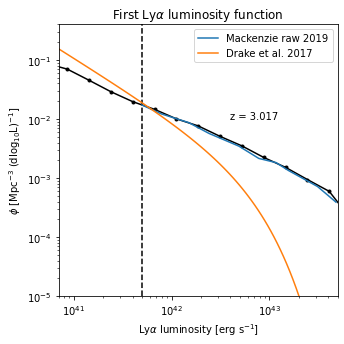

In [163]:
plt.figure(figsize=(5,5))

#luminosity function per unit volume per unit dlogL
lya_lum_fun = counts_sum/10**6/(np.log10(lyabins[1:])-np.log10(lyabins[:-1]))

plt.plot(lyabins_average, lya_lum_fun, '.k-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Ly$\alpha$ luminosity [erg s$^{-1}$]')
plt.ylabel(r'$\phi$ [Mpc$^{-3}$ (dlog$_{10}$L)$^{-1}$]')
plt.text(4e42, 1e-2, 'z = %.3f' %redshift[0] )
plt.title(r'First Ly$\alpha$ luminosity function')
plt.xlim(7e40, 5e43)
plt.ylim(1e-5, 4e-1)

#these are the results from the same analysis done by Mackenzie
mackenzie =  np.loadtxt('Mackenzie.txt')
plt.plot(mackenzie[:,0], mackenzie[:,1], label='Mackenzie raw 2019')

#luminosity function defined by Drake et al 2017
def drake_fun(L, phi_star, alpha, L_star):
    return np.log(10)*phi_star*(L/L_star)**(alpha +1)*np.exp(-L/L_star)

#from Drake 2017
alpha = -2.03
L_star = 10**(42.72)
phi_star = 10**(-3.1)

x_axis = np.logspace(40.3, 43.5, 100)
drake = drake_fun(x_axis, phi_star, alpha, L_star)
plt.plot(x_axis, drake, label='Drake et al. 2017')

plt.legend()
plt.vlines(5e41, ymin=1e-5, ymax=4e-1, ls='--', color='black') #this is the value from which I can consider a normalisation

In [164]:
#probability of extracting a galaxy inside a given L_lya bin evaluated as the ratio in correspondence of the average point of  
#the bin between Drake Schechter function and my function
#for values below 5e41 I just take them all (p = 1)
perc = []

for i in range(len(lyabins_average)):
    if lyabins_average[i]>5e41:
        perc.append(drake_fun(lyabins_average[i], phi_star, alpha, L_star)/lya_lum_fun[i])
    else:
        perc.append(1)

#creating a boolean array of the same dimension of the galaxy elements extracting true or false based on the computed prob
hitormiss = []
np.random.seed(10)
for i in range(len(belonging_bin)):
    if belonging_bin[i] == 'None':
            hitormiss.append('False')  #I add true for all the galaxy for which SFR = 0, it doesn't really matter 
    for j in range(len(lyabins_average)):
        if belonging_bin[i] == j:
            hitormiss.append(np.random.choice(['True', 'False'], p=[perc[j], 1-perc[j]]))

hitormiss = np.array(hitormiss)
L_lya_corr = L_lya[0][hitormiss == 'True']  #taking only the extracted true values

#doing again the Lya luminosity function with the extracted True elements
counts_corr = [[] for i in range(len(lyabins_average))]
pos_lya_sel = [[] for i in range(len(lyabins_average))]

for i in range(len(L_lya_corr)):
    for j in range(len(lyabins)):
        if L_lya_corr[i] == lyabins[-1]:
            counts_corr[-1].append(i)
            print('last one')
            break
        if L_lya_corr[i] < lyabins[0]:
            break
        if L_lya_corr[i] <lyabins[j]:
            counts_corr[j-1].append(i)
            break


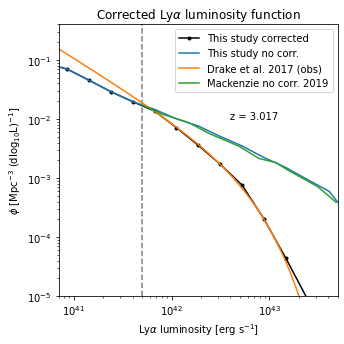

In [165]:
#and corrected luminosity function again
counts_corr_sum = []

for i in range(len(counts_corr)):
    counts_corr_sum.append(len(counts_corr[i]))
    
counts_corr_sum = np.array(counts_corr_sum)

plt.figure(figsize=(5,5))

lya_lum_fun_corr = counts_corr_sum/10**6/(np.log10(lyabins[1:])-np.log10(lyabins[:-1]))
plt.plot(lyabins_average, lya_lum_fun_corr, '.k-', label='This study corrected')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Ly$\alpha$ luminosity [erg s$^{-1}$]')
plt.ylabel(r'$\phi$ [Mpc$^{-3}$ (dlog$_{10}$L)$^{-1}$]')
plt.text(4e42, 1e-2, 'z = %.3f' %redshift[0] )
plt.title(r'Corrected Ly$\alpha$ luminosity function')
plt.xlim(7e40, 5e43)
plt.ylim(1e-5, 4e-1)

plt.plot(lyabins_average, lya_lum_fun, label='This study no corr.')
plt.plot(x_axis, drake, label='Drake et al. 2017 (obs)')
plt.plot(mackenzie[:,0], mackenzie[:,1], label='Mackenzie no corr. 2019')

plt.vlines(5e41, ymin=1e-5, ymax=4e-1, ls='--', color='grey')
plt.legend()

plt.savefig('corrected_luminosity_function.pdf', format='pdf')# bbox_inches='tight')

2526 2526


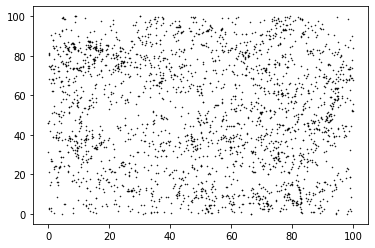

In [170]:
from corr_functions import *
Pos_corr = Pos[0][hitormiss == 'True']
Pos_corr = Pos_corr[L_lya_corr>=1e42]
print(len(Pos_corr), len(L_lya_corr[L_lya_corr>=1e42]))
Pos_Mpc_corr = Pos_corr/0.6777
plt.plot(Pos_Mpc_corr[:,0], Pos_Mpc_corr[:,1], '.k', markersize=1)

In [171]:
bins = np.logspace(np.log10(0.19), np.log10(19), 7)
#bins[0] = 0.15

N_boot = 300
xi_100 = np.zeros((N_boot, len(bins)-1))

for i in range(N_boot):
    bins_cen100, xi_100[i], _ = corr_func(700, bins, Pos_Mpc_corr, 0,100, False)

[108.3570274   26.44861388   7.24551987   2.21072232   0.72357611
   0.16640205]
[16.21327288  2.59412366  0.5998911   0.12970618  0.04600516  0.01697124]


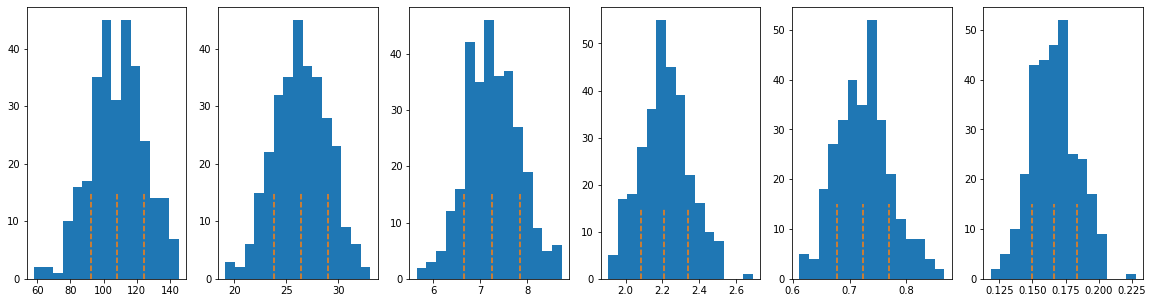

In [174]:
fig, ax = plt.subplots(1,len(bins)-1,figsize=(20,5))
med_xi100 = np.median(xi_100, axis=0)
sigma_xi100 = (np.percentile(xi_100, 75, axis=0) - np.percentile(xi_100, 25, axis=0))*0.7413
print(med_xi100)
print(sigma_xi100)
for i,j in enumerate(ax):
    j.hist(xi_100[:,i], bins=15) 
    j.vlines(med_xi100[i], 0, 15, ls='--', color='tab:orange')
    j.vlines(med_xi100[i]-sigma_xi100[i], 0, 15, ls='--', color='tab:orange')
    j.vlines(med_xi100[i]+sigma_xi100[i], 0, 15, ls='--', color='tab:orange')

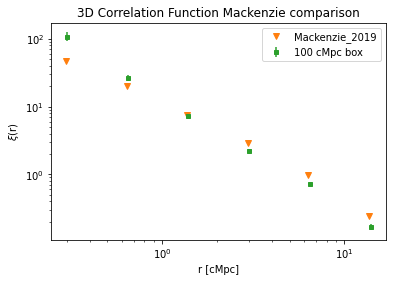

In [173]:
plt.errorbar(bins_cen100, med_xi100, sigma_xi100, ls='', color='tab:green', marker = 's', markersize=4, label='100 cMpc box')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(0.2, 500)
xaxis= np.logspace(np.log10(bins[0]), np.log10(bins[-1]), 100)

def fit_f(r, r0, gamma):
    return (r0/r)**(gamma)

#from scipy.optimize import curve_fit
#popt, pcov = curve_fit(fit_f, bins_cen100[0], xi100, p0=[2., 1.8])
#print(popt)

mack = np.genfromtxt('Mackenzie_corrdata.txt')
plt.plot(mack[:,0], mack[:,1], ls='', marker='v', color='tab:orange', label='Mackenzie_2019')
#plt.plot(xaxis, fit_f(xaxis, popt[0], popt[1]), label=r'$\xi$(r) = (%.2f/r)$^{%.2f}$' %(popt[0], popt[1]))
plt.xlabel(r'r [cMpc]')
plt.ylabel(r'$\xi$(r)')
plt.legend()
plt.title('3D Correlation Function Mackenzie comparison')

plt.savefig('Mack_comp.pdf', format='pdf')

In [103]:
filename = generic_name + specific_name[0] + '0.hdf5'
myfile = h5py.File(filename, 'r')
for i in myfile['Header'].attrs:
    print(i)
    
print('Box size = ', myfile['Header'].attrs['BoxSize'])
print('H = ', myfile['Header'].attrs['HubbleParam'])
print('Omega0 = ', myfile['Header'].attrs['Omega0'])

BoxSize
E(z)
ExpansionFactor
Flag_Cooling
Flag_DoublePrecision
Flag_Feedback
Flag_IC_Info
Flag_Metals
Flag_Sfr
Flag_StellarAge
H(z)
HubbleParam
MassTable
NTask
Ngroups
Nids
Nsubgroups
NumFilesPerSnapshot
NumPart_ThisFile
NumPart_Total
NumPart_Total_HighWord
Omega0
OmegaBaryon
OmegaLambda
Redshift
RunLabel
SendOffSetTask
Time
TotNgroups
TotNids
TotNsubgroups
Box size =  67.77
H =  0.6777
Omega0 =  0.307
